<a href="https://colab.research.google.com/github/Mohamadaminlotfi98/Spike-Sorting-with-Diffrent-deep-learning-models/blob/main/classifier_Transformer___spike_sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive

Mounted at /gdrive
/gdrive/MyDrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as t
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
!pip install pymatreader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pymatreader import read_mat
data = read_mat('Spike/artificial_data_snoise_0.5_seed_0.mat')

In [ ]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Sep 11 17:47:49 2017',
 '__version__': '1.0',
 '__globals__': [],
 'signal': {'data': array([ 0.05376671,  1.35020237,  0.60505048, ...,  0.0991082 ,
         -0.77801545, -1.00646371]), 'dt': 5e-05, 'start': 0},
 'truth': {'nNeurons': 3,
  'timeStamps': array([9.55721594e-03, 3.40350671e-01, 1.09830778e+00, ...,
         1.98491159e+02, 1.98780009e+02, 1.99558734e+02]),
  'neuronTags': array([1, 1, 1, ..., 3, 3, 3], dtype=uint8),
  'start': 0,
  'stop': 200}}

In [ ]:
spike_class = data['truth']['neuronTags']
spike_data = data['signal']['data']
spike_times = data['truth']['timeStamps']/5e-05

In [ ]:
idx_spike = spike_times.astype(int)
num_spike = len(spike_times)
num_sample_forward = 60
num_sample_backward = 20
spike_curve = np.zeros((num_spike, num_sample_forward - num_sample_backward))
for i in range(num_spike):
    spike_curve[i] = spike_data[(idx_spike[i] + num_sample_backward):(idx_spike[i] + num_sample_forward)]


Text(0, 0.5, 'uV')

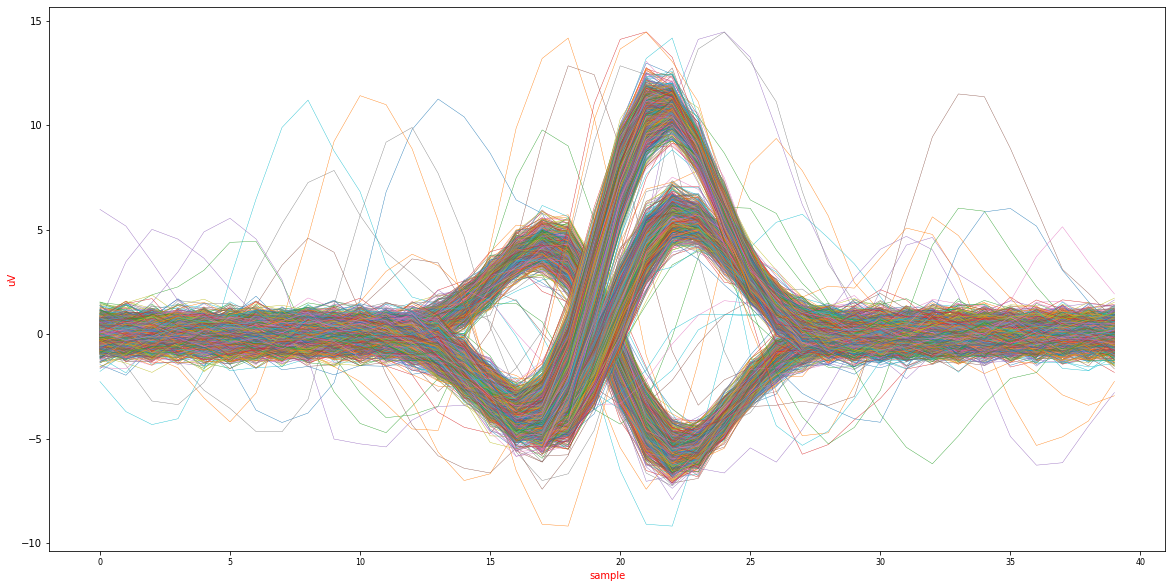

In [ ]:
plt.figure(figsize=(20,10))
for i in range(num_spike):
    plt.plot(spike_curve[i],linewidth=0.4)
plt.xticks(fontsize=8)
plt.xlabel('sample',color='red')
plt.ylabel('uV',color='red')

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.3 MB/s eta 0:00:00


In [ ]:
class TransformerSpikeSorter(nn.Module):
    def __init__(self, input_size):
        super(TransformerSpikeSorter, self).__init__()
        self.input_size = input_size

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(input_size, nhead=32, dim_feedforward=5000),
            num_layers=1)
        self.fc = nn.Linear(input_size, 3)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.fc(x)
        return x




# Example usage
input_size = 40  # size of input spike templates
model = TransformerSpikeSorter(input_size)



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device\n")
model.to(device)    # Convert model parameters and buffers to CPU or Cuda

The model will be running on cpu device



TransformerSpikeSorter(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=5000, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=5000, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

In [ ]:
# ss = torch.randn([1,32]).to(device)
# print(model(ss).shape)

torch.Size([1, 3])


<function matplotlib.pyplot.show(close=None, block=None)>

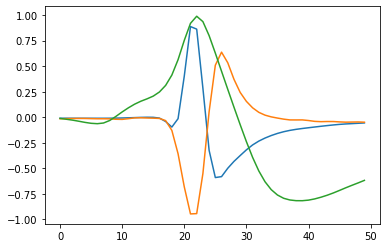

In [ ]:
mean_waveforms = []
unique_labels = np.unique(spike_class)
for label in unique_labels:
    label_waveforms = spike_curve[spike_class == label]
    mean_waveform = np.mean(label_waveforms, axis=0)
    mean_waveforms.append(mean_waveform)
plt.plot(mean_waveforms[0],label = 'Neuron1')
plt.plot(mean_waveforms[1],label = 'Neuron2')
plt.plot(mean_waveforms[2],label = 'Neuron3')
plt.show

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import stats

# Compute the z-score for each spike curve along axis=0
spike_curve_zscore = stats.zscore(spike_curve, axis=0)

label = spike_class-1
data = spike_curve_zscore
X_train, test_data, X_label, test_label = train_test_split(data, label, test_size=0.50,stratify=label,shuffle = True)
train_data, val_data, train_label, val_label = train_test_split(X_train, X_label, test_size=0.05,stratify=X_label,shuffle = True)
# Convert the data and labels to PyTorch tensors
train_inputs = torch.from_numpy(train_data).float()
val_inputs = torch.from_numpy(val_data).float()
test_inputs = torch.from_numpy(test_data).float()
train_labels = torch.from_numpy(train_label).float()
val_labels = torch.from_numpy(val_label).float()
test_labels = torch.from_numpy(test_label).float()

In [ ]:
print(train_inputs.shape)
print(val_inputs.shape)
print(test_inputs.shape)
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

torch.Size([1669, 50])
torch.Size([88, 50])
torch.Size([1757, 50])
torch.Size([1669])
torch.Size([88])
torch.Size([1757])


In [ ]:
num_epochs = 25

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

inputs = torch.tensor([])

# Train the network
for epoch in range(num_epochs):
  training_loss = 0
  loss_back = 0

  for i in range(0, train_inputs.size(0)):
    # Get the input and labels for the current batch
    inputs = train_inputs[i:i+1].to(device)
    labels = train_labels[i:i+1].to(device)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels.long())
    training_loss += loss
    loss_back += loss

    # Zero the gradients
    if i % 100 == 0:
        optimizer.zero_grad()

        # Backward pass and optimization
        loss_back.backward()
        optimizer.step()
        loss_back = 0

  training_loss = training_loss/train_inputs.size(0)
  print('******************************************************************')
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, training_loss))

  with torch.no_grad():
    correct = 0
    val_loss = 0

    for j in range(0,val_inputs.size(0)):
      # Get the input and labels for the current batch
      inputs = val_inputs[j:j+1].to(device)
      labels = val_labels[j:j+1].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels.long())

      val_loss += loss

      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()

    val_loss = val_loss/val_inputs.size(0)
    print('Validation Loss: {:.4f}'.format(val_loss))
    print('Validation Accuracy: {:.2f}% ({}/{})'.format(100*correct/val_inputs.size(0), correct, val_inputs.size(0)))


******************************************************************
Epoch [1/25], Loss: 0.1937
Validation Loss: 0.0529
Validation Accuracy: 100.00% (88/88)
******************************************************************
Epoch [2/25], Loss: 0.0722
Validation Loss: 0.0390
Validation Accuracy: 100.00% (88/88)
******************************************************************
Epoch [3/25], Loss: 0.0484
Validation Loss: 0.0275
Validation Accuracy: 100.00% (88/88)
******************************************************************
Epoch [4/25], Loss: 0.0328
Validation Loss: 0.0200
Validation Accuracy: 100.00% (88/88)
******************************************************************
Epoch [5/25], Loss: 0.0238
Validation Loss: 0.0156
Validation Accuracy: 100.00% (88/88)
******************************************************************
Epoch [6/25], Loss: 0.0185
Validation Loss: 0.0124
Validation Accuracy: 100.00% (88/88)
******************************************************************
Epo

Test Accuracy: 91.79% (3108/3386) loss: 0.48659089900287733


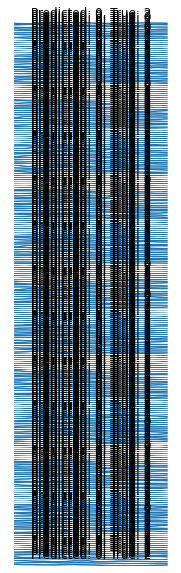

In [ ]:
# Put the model in evaluation mode
model.eval()

# Define variables for tracking accuracy and loss
test_loss = 0
correct = 0
total = 0

# Lists to store wrong predictions
wrong_inputs = []
wrong_predicted = []
wrong_labels = []

# Loop over the test dataset
with torch.no_grad():
    for i in range(len(test_data)):
        # Get inputs and labels from the test dataset
        inputs = test_inputs[i:i+1].to(device)
        labels = test_labels[i:i+1].long().to(device)
        # Forward pass
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Check for wrong predictions
        if predicted.item() != labels.item():
            wrong_inputs.append(inputs.cpu().numpy())
            wrong_predicted.append(predicted.item())
            wrong_labels.append(labels.item())

# Compute average test loss and accuracy
test_loss /= len(test_data)
test_acc = 100 * correct / total

# Print results
print('Test Accuracy: {:.2f}% ({}/{})'.format(100*correct/test_inputs.size(0) , correct, test_inputs.size(0)),"loss:",test_loss)
# Plot wrong predictions
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(wrong_inputs), figsize=(3,10))

for i in range(len(wrong_inputs)):
    axs[i].plot(wrong_inputs[i][0])
    axs[i].set_title(f"Predicted: {wrong_predicted[i]}, True: {wrong_labels[i]}")
    axs[i].axis('off')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
input = torch.from_numpy(spike_curve).float().to(device)
outputs_encode = []
outputs_decode = []
for spike in input:
    spike = spike.to(device)  # Move the input tensor to the same device as the model
    output_encode = model.transformer_encoder(spike.unsqueeze(0))
encoded = torch.cat(output_encode)
num_inputs = len(spike_curve)
fig, axs = plt.subplots(nrows=20, ncols=2, figsize=(5, 10))
for i in range(20):
    axs[i, 0].plot(spike_curve[i])
    axs[i, 1].plot(encoded[i].detach().numpy())
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
plt.show()


TypeError: ignored

*************************************
C_Easy1_noise005
Test Accuracy: 99.63% (3501/3514) loss: 0.01411913991590692


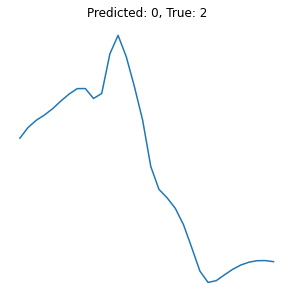

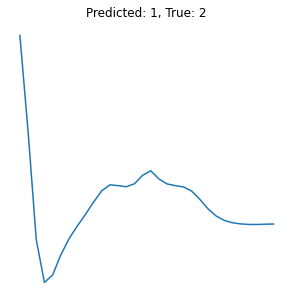

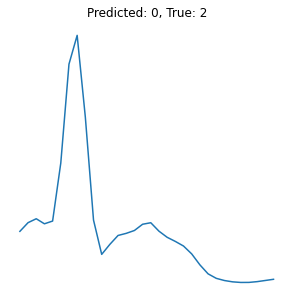

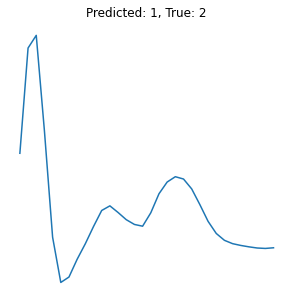

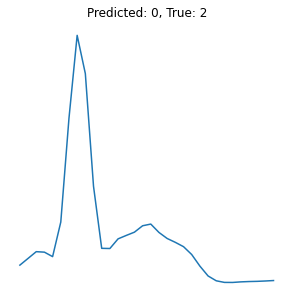

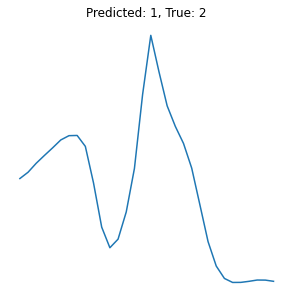

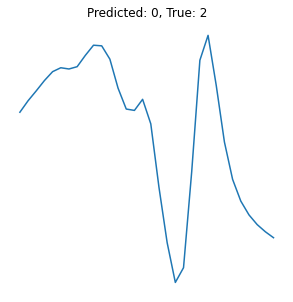

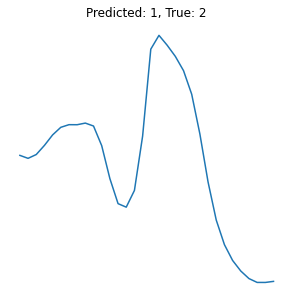

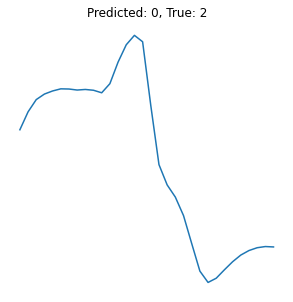

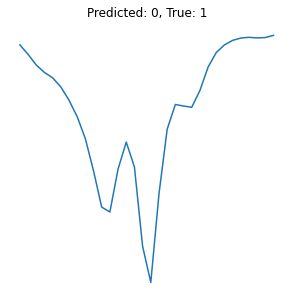

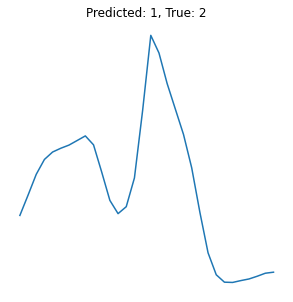

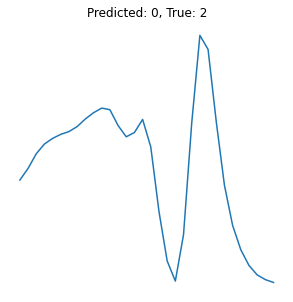

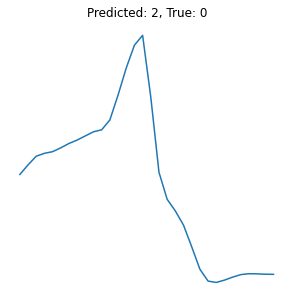

*************************************
C_Easy1_noise01
Test Accuracy: 99.60% (3508/3522) loss: 0.017388246602737484


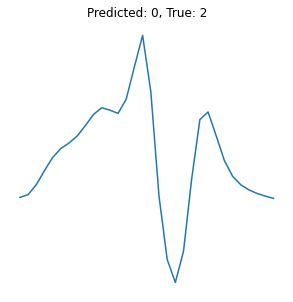

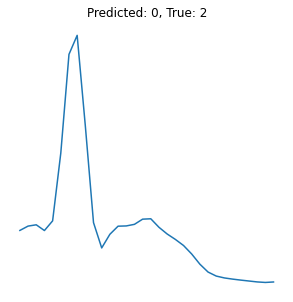

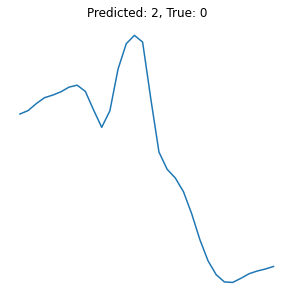

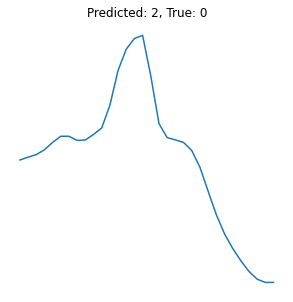

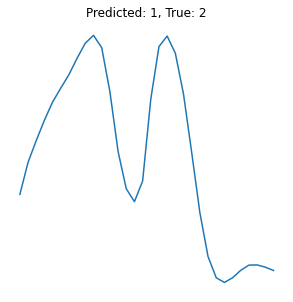

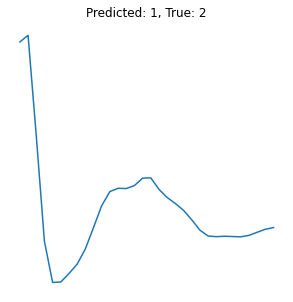

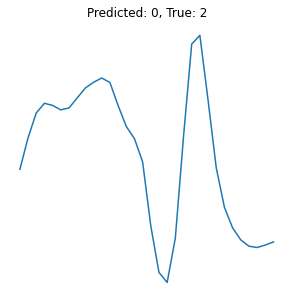

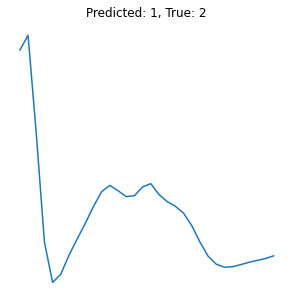

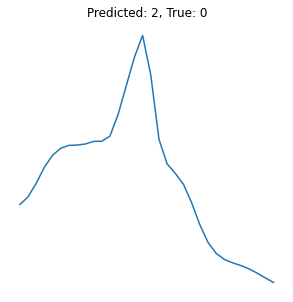

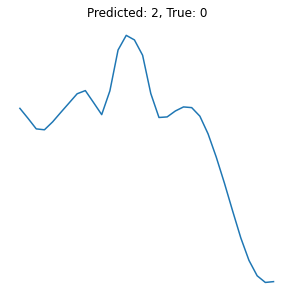

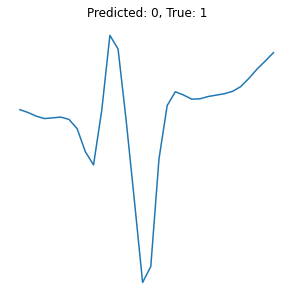

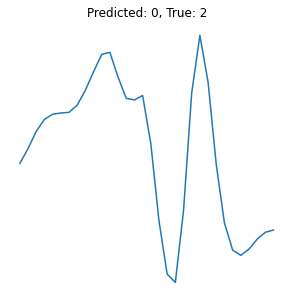

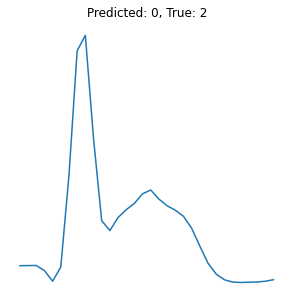

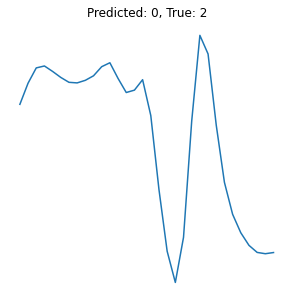

*************************************
C_Easy1_noise015
Test Accuracy: 99.40% (3456/3477) loss: 0.021637850608864837


<ipython-input-101-eccca4fa8460>:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(5,5))


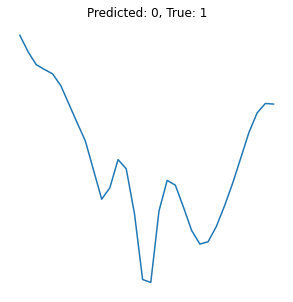

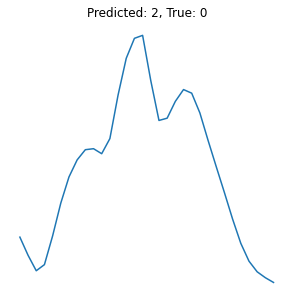

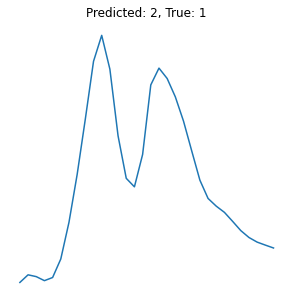

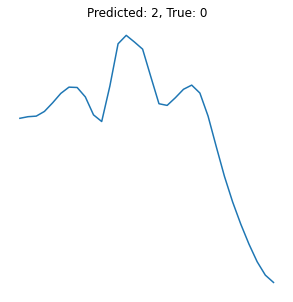

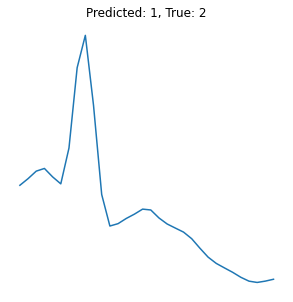

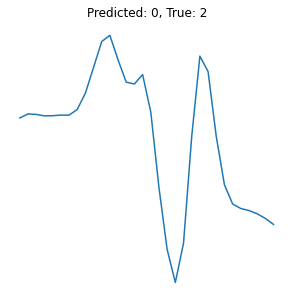

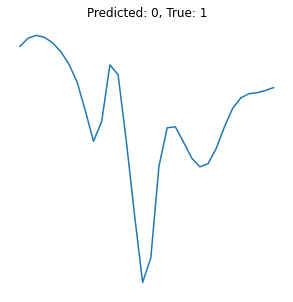

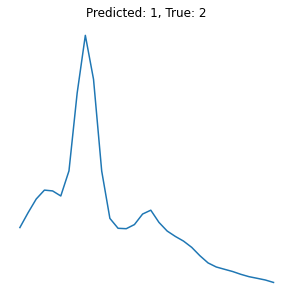

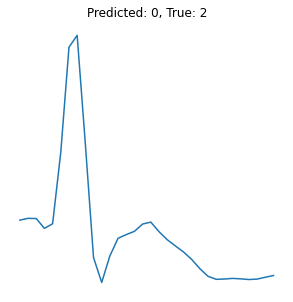

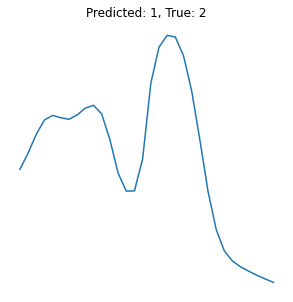

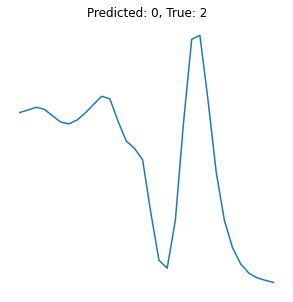

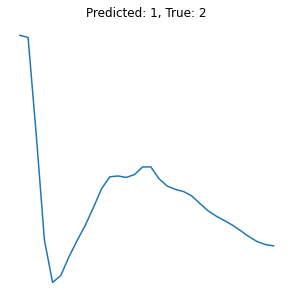

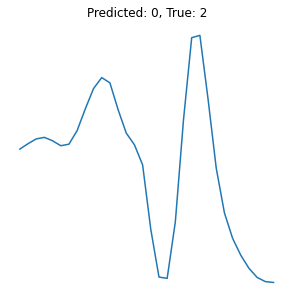

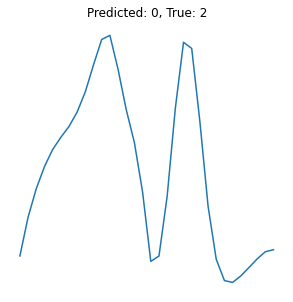

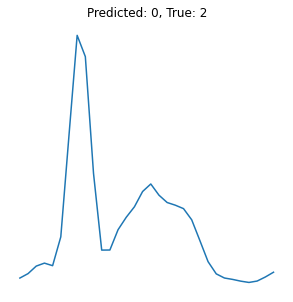

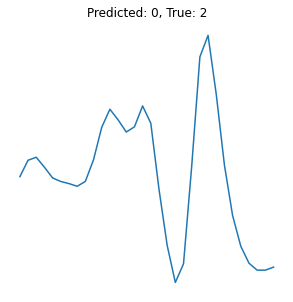

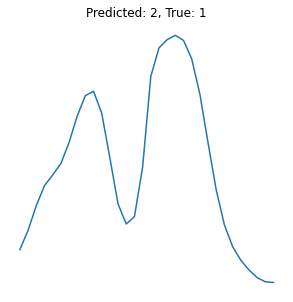

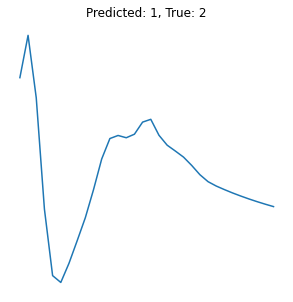

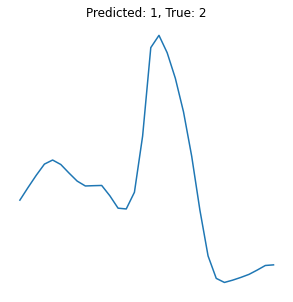

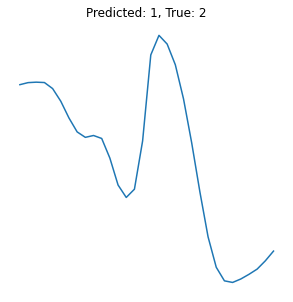

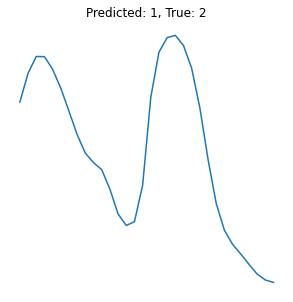

*************************************
C_Easy1_noise02
Test Accuracy: 99.28% (3449/3474) loss: 0.030350922687042443


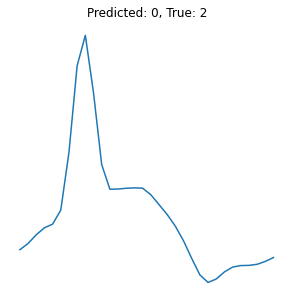

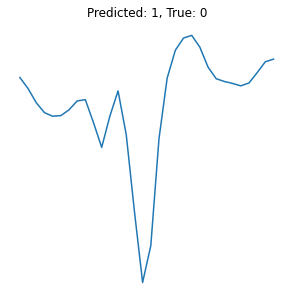

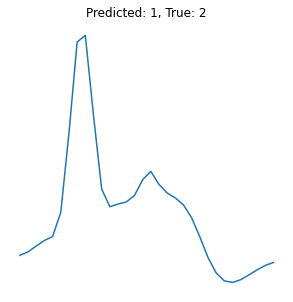

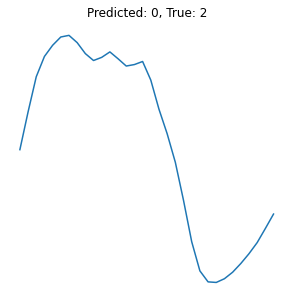

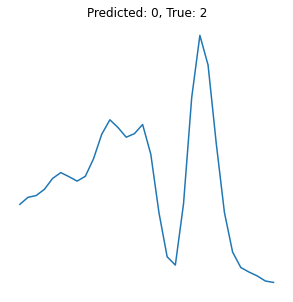

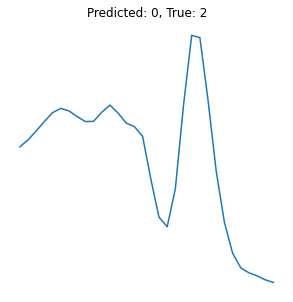

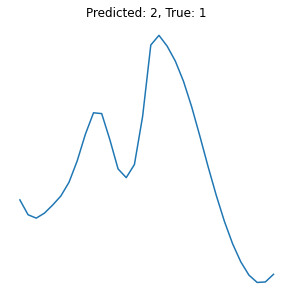

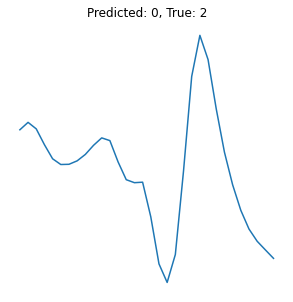

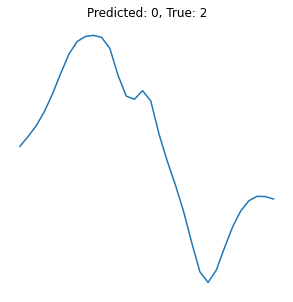

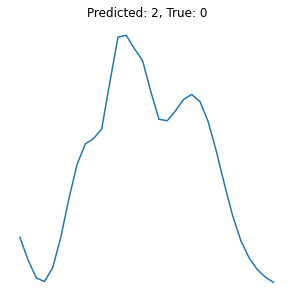

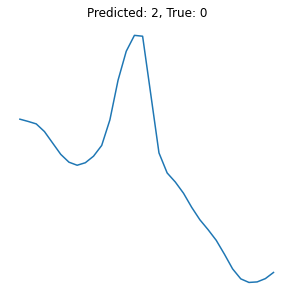

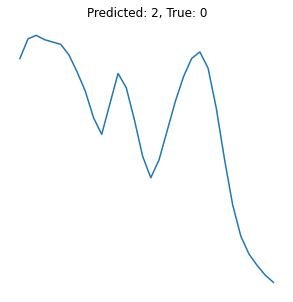

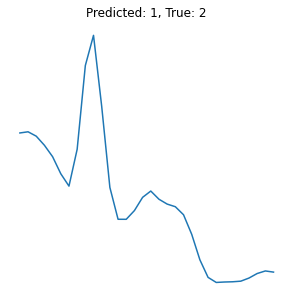

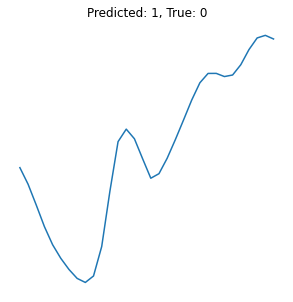

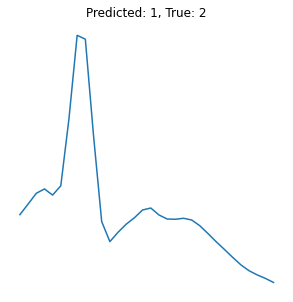

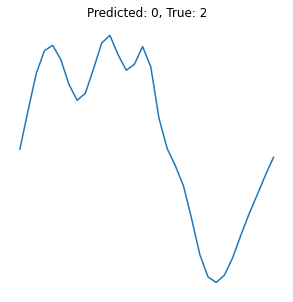

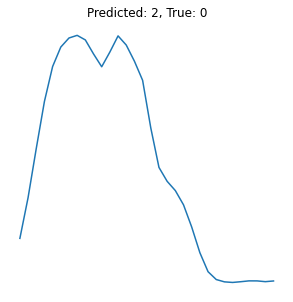

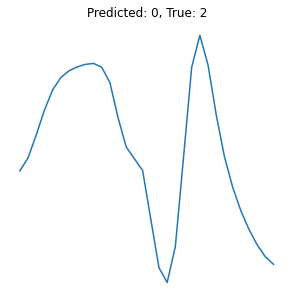

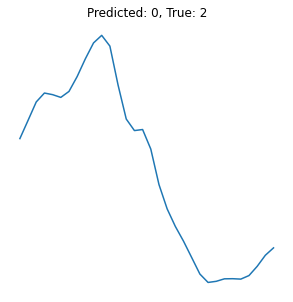

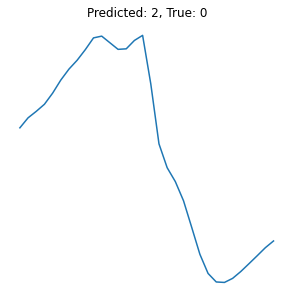

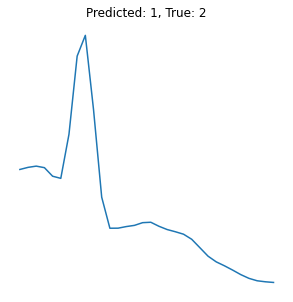

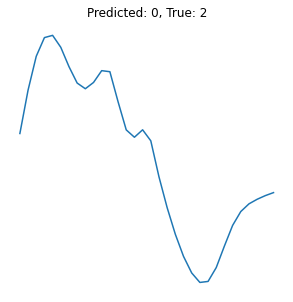

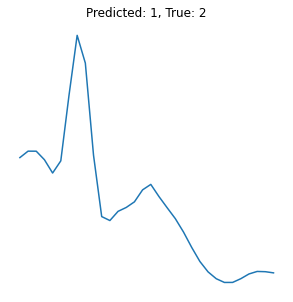

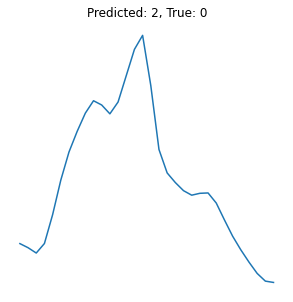

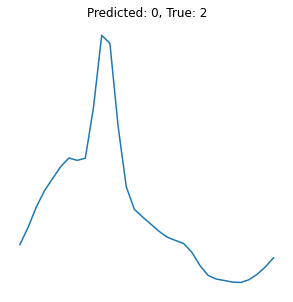

*************************************
C_Easy1_noise025
Test Accuracy: 98.85% (3260/3298) loss: 0.04179416644062763


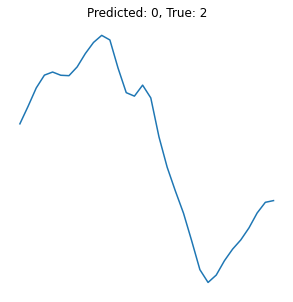

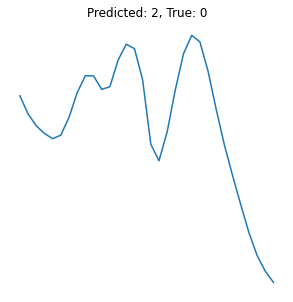

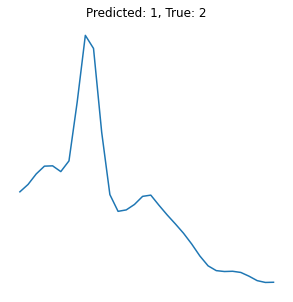

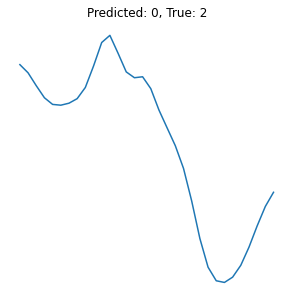

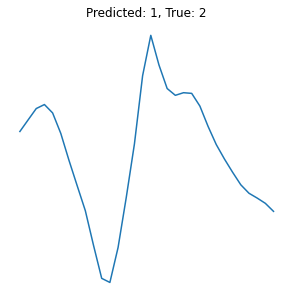

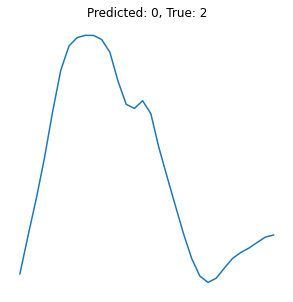

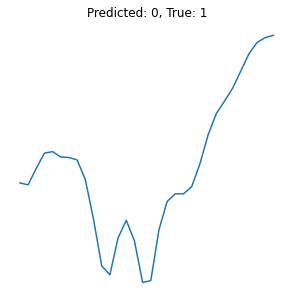

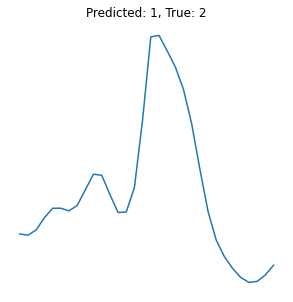

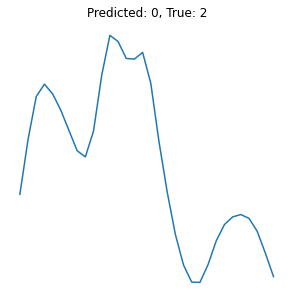

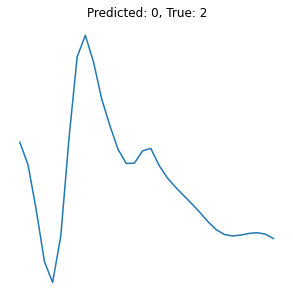

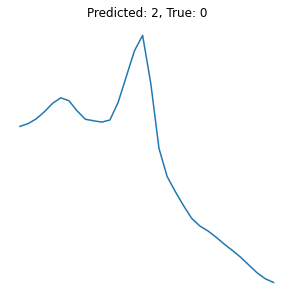

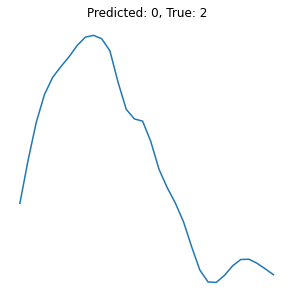

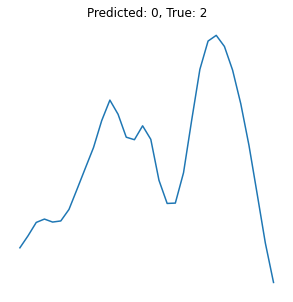

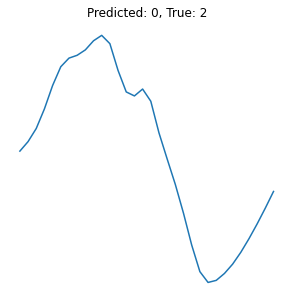

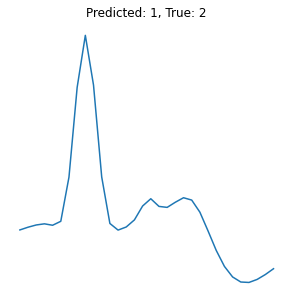

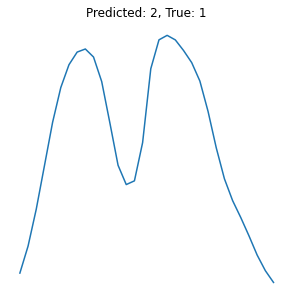

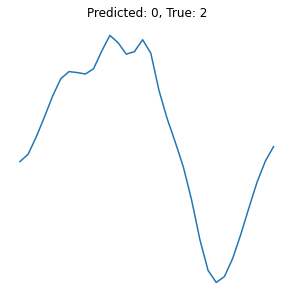

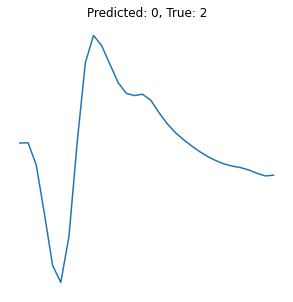

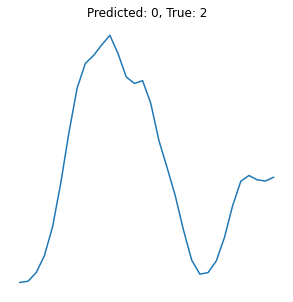

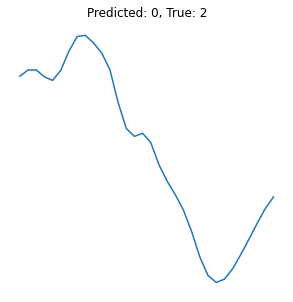

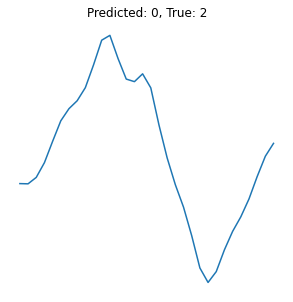

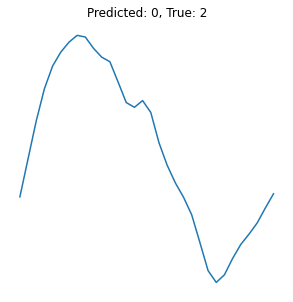

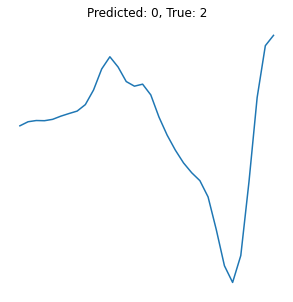

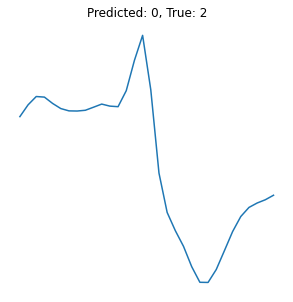

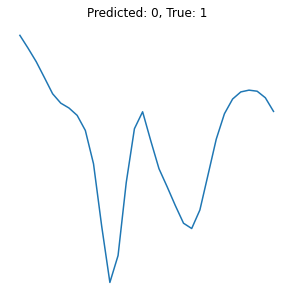

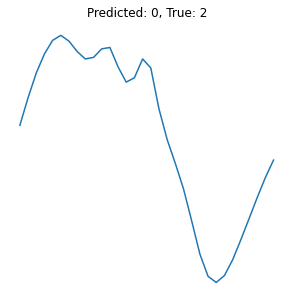

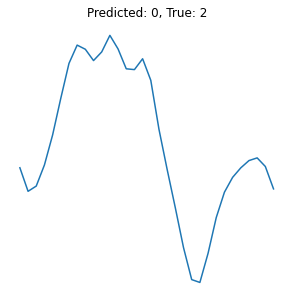

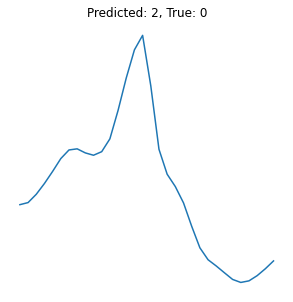

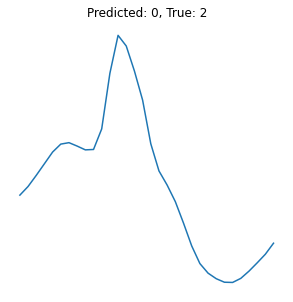

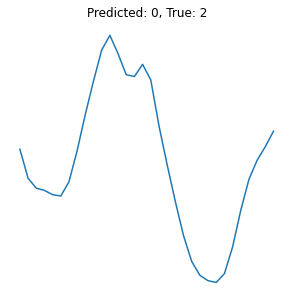

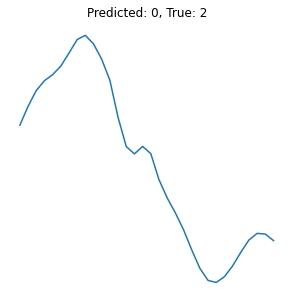

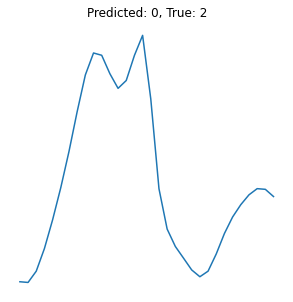

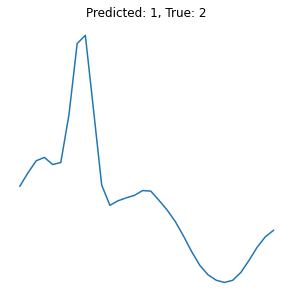

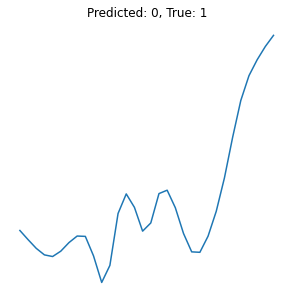

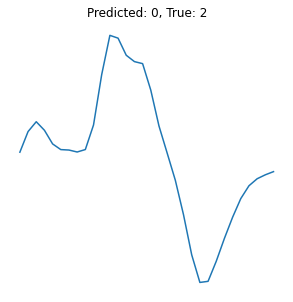

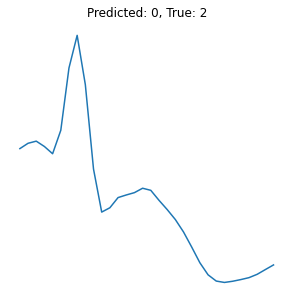

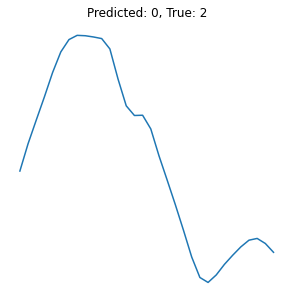

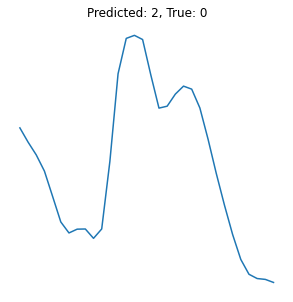

*************************************
C_Easy1_noise03
Test Accuracy: 98.16% (3411/3475) loss: 0.0676574383814913


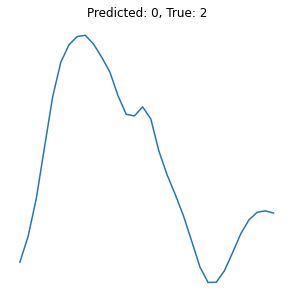

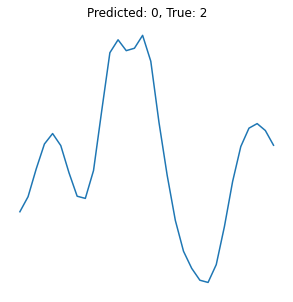

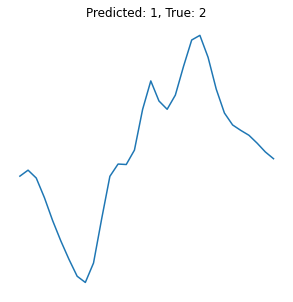

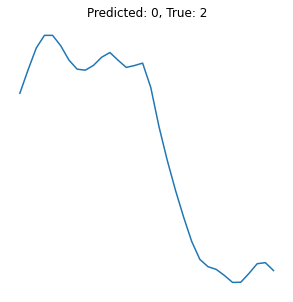

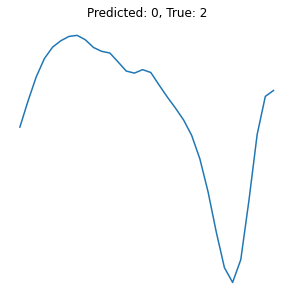

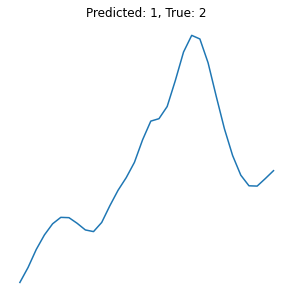

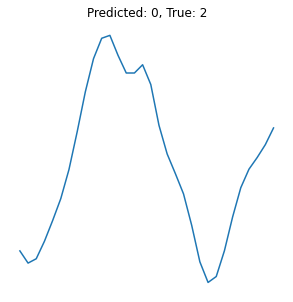

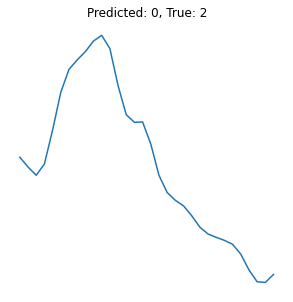

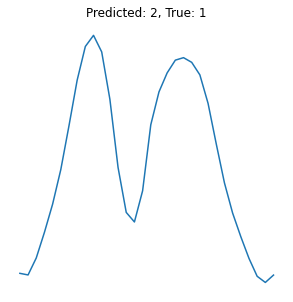

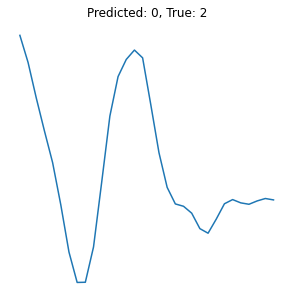

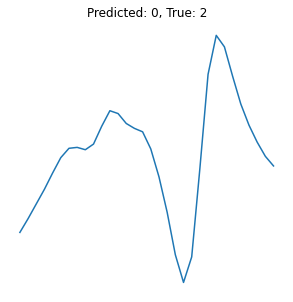

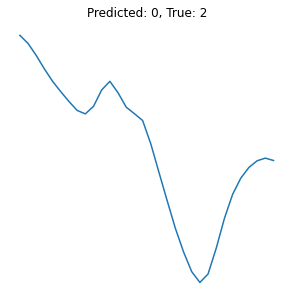

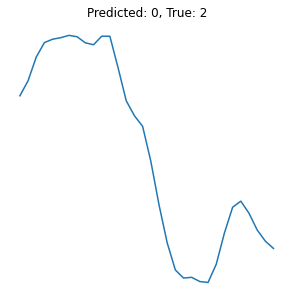

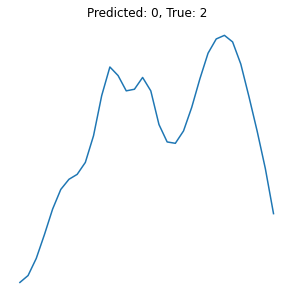

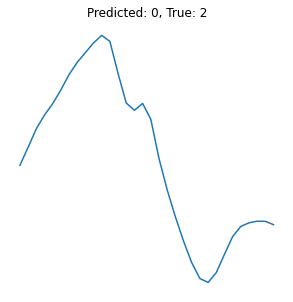

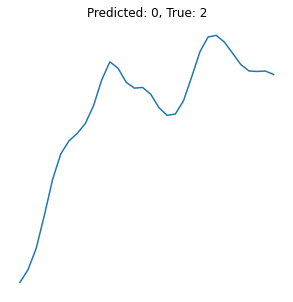

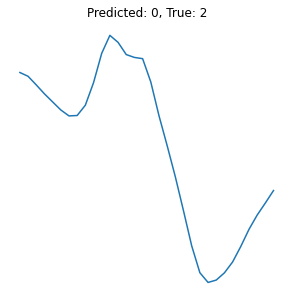

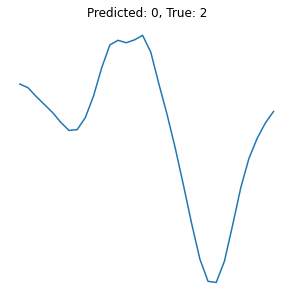

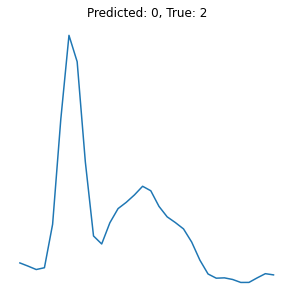

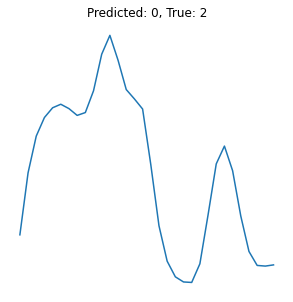

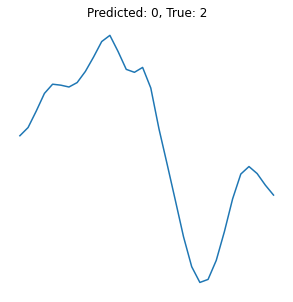

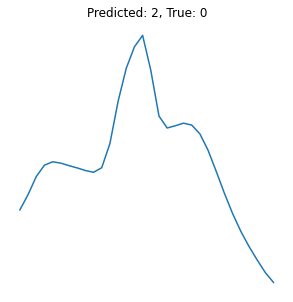

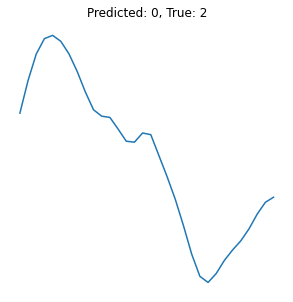

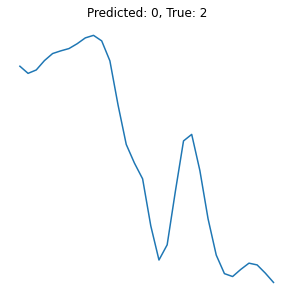

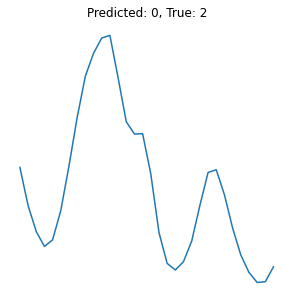

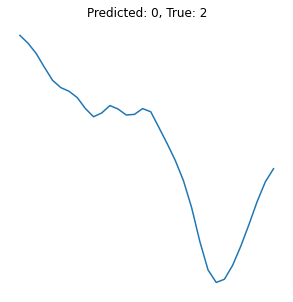

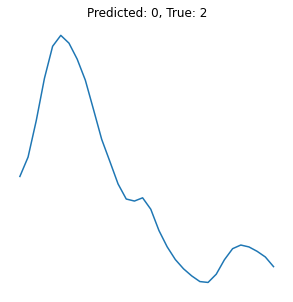

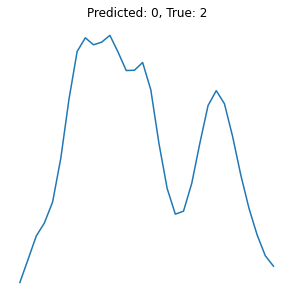

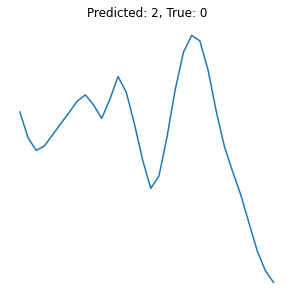

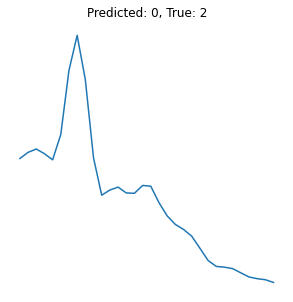

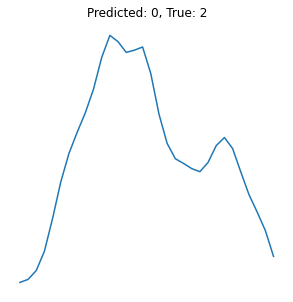

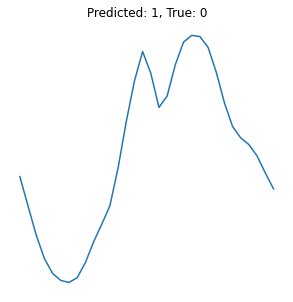

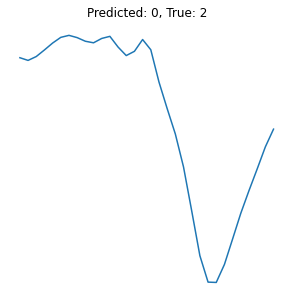

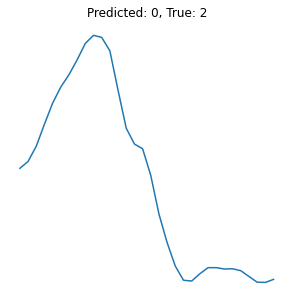

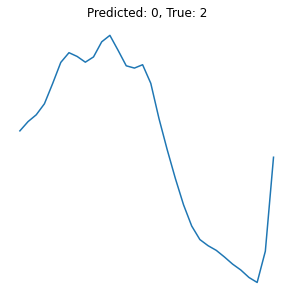

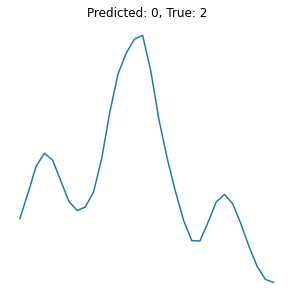

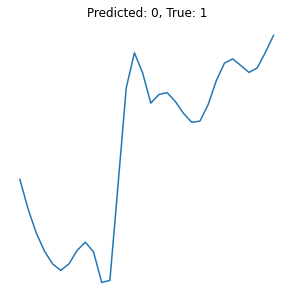

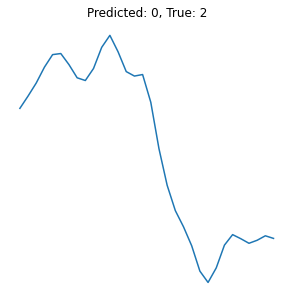

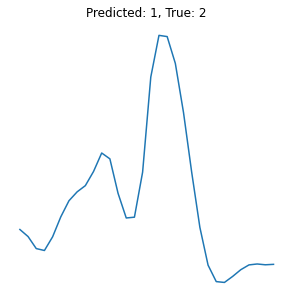

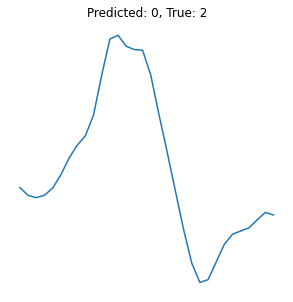

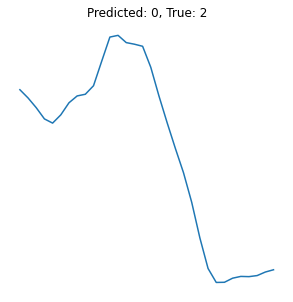

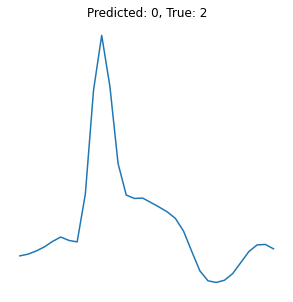

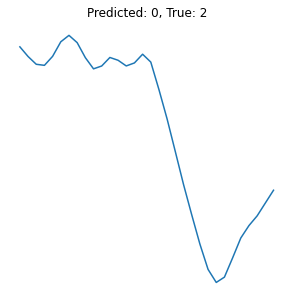

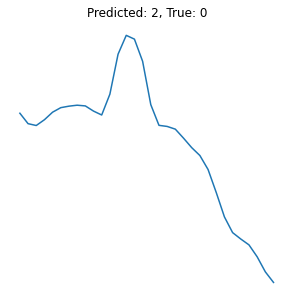

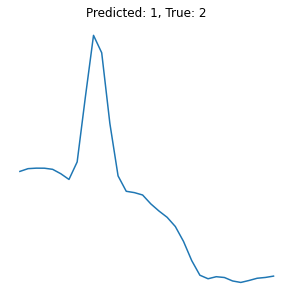

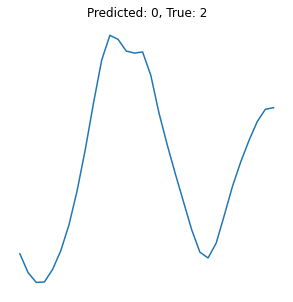

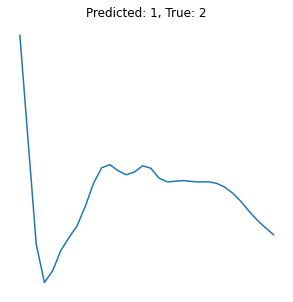

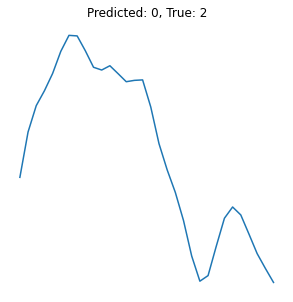

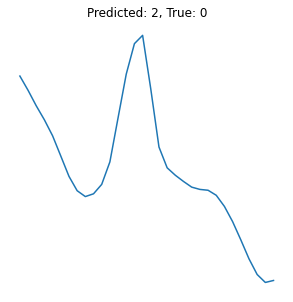

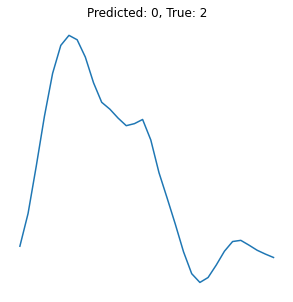

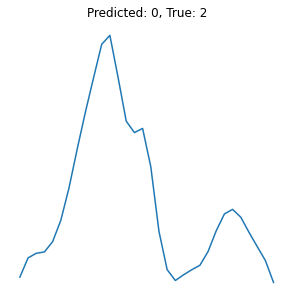

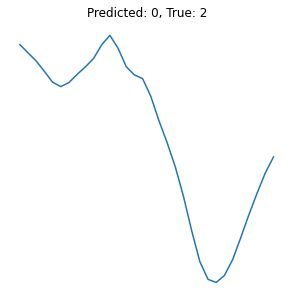

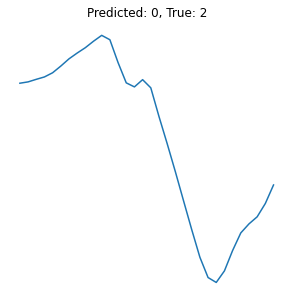

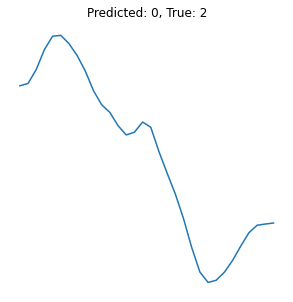

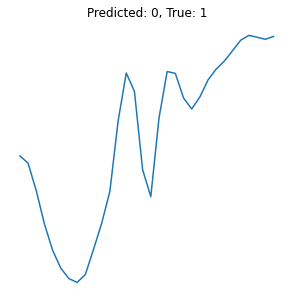

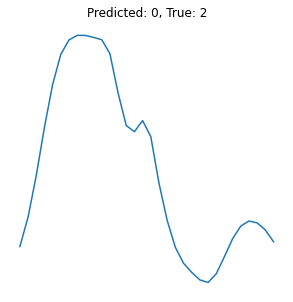

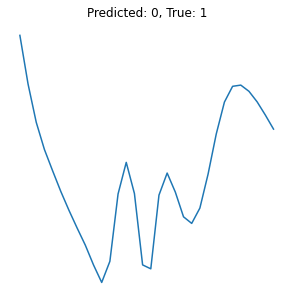

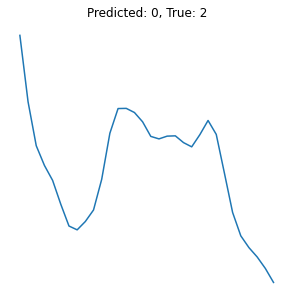

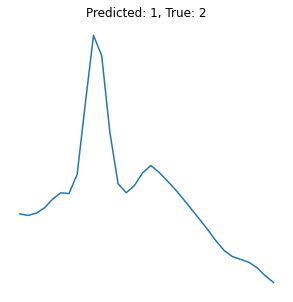

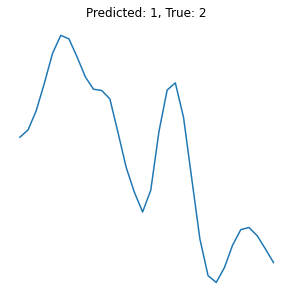

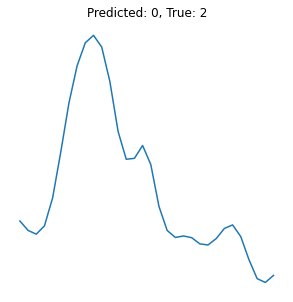

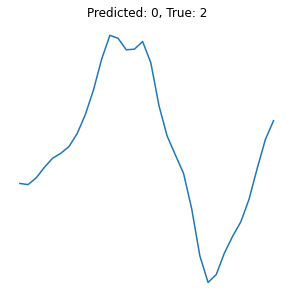

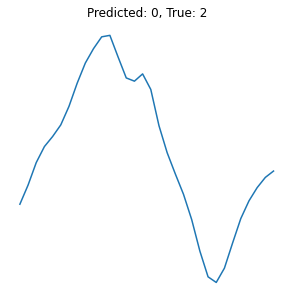

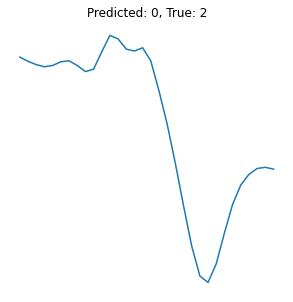

*************************************
C_Easy1_noise035
Test Accuracy: 97.26% (3437/3534) loss: 0.11462330212933539


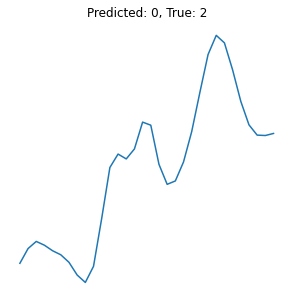

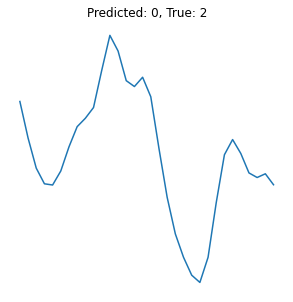

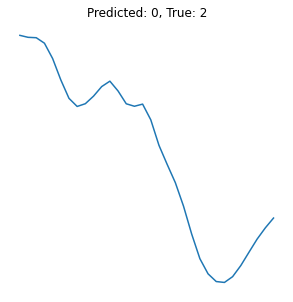

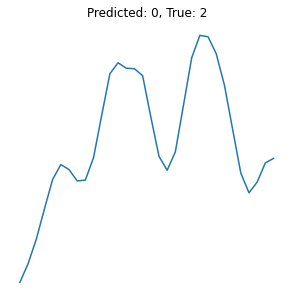

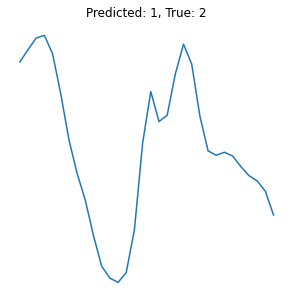

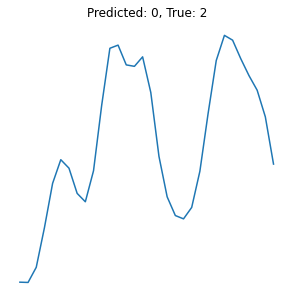

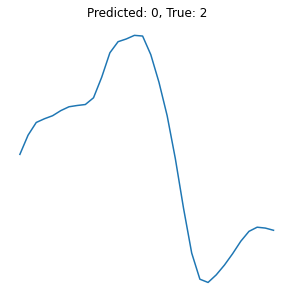

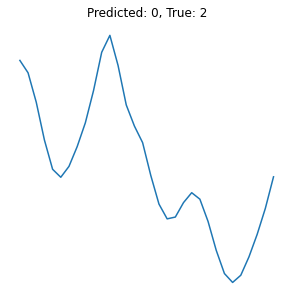

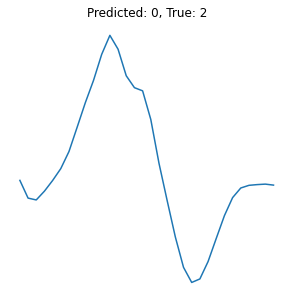

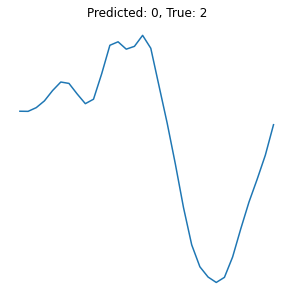

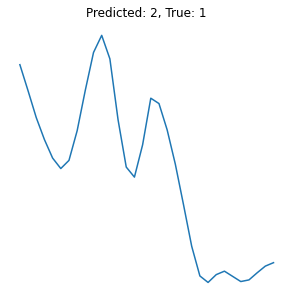

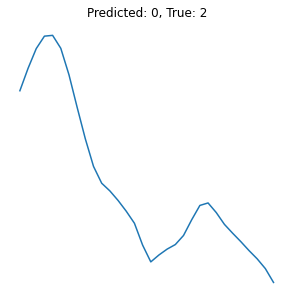

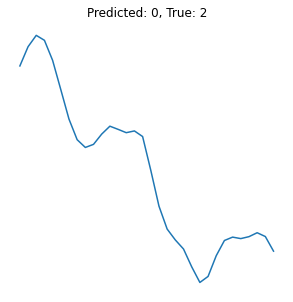

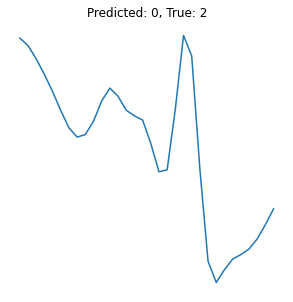

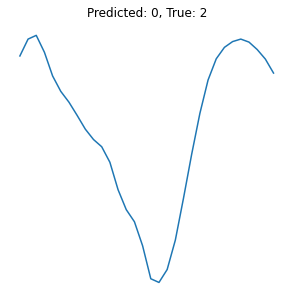

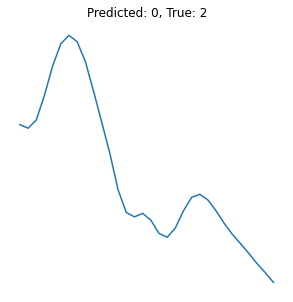

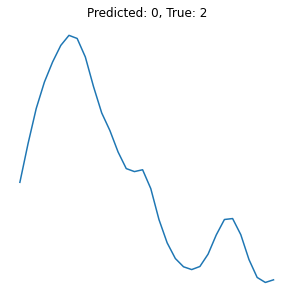

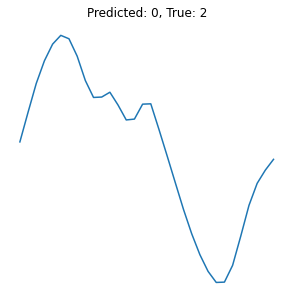

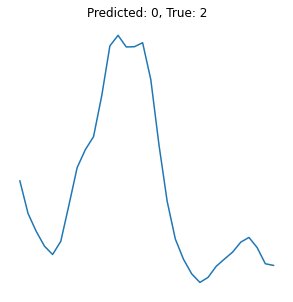

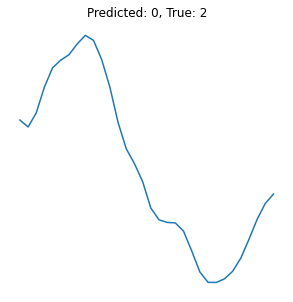

In [ ]:
dataset0 = ['C_Easy1_noise005','C_Easy1_noise01','C_Easy1_noise015','C_Easy1_noise02','C_Easy1_noise025','C_Easy1_noise03','C_Easy1_noise035','C_Easy1_noise04']
dataset1 =[ 'C_Easy2_noise005','C_Easy2_noise01','C_Easy2_noise015','C_Easy2_noise02']
dataset2 =[ 'C_Difficult1_noise005','C_Difficult1_noise01','C_Difficult1_noise015','C_Difficult1_noise02']
dataset3 =[ 'C_Difficult2_noise005','C_Difficult2_noise01','C_Difficult2_noise015','C_Difficult2_noise02']
criterion = nn.CrossEntropyLoss()
for read in dataset0:

  data = read_mat('Simulator/'+read+'.mat')
  spike_class = data['spike_class'][0][:]
  spike_data = data['data']
  spike_times = data['spike_times']
  idx_spike=spike_times
  num_spike=len(spike_times)
  num_sample_forward=40
  num_sample_backward=8
  spike_curve=np.zeros((num_spike,num_sample_forward-num_sample_backward))
  for i in range(num_spike):
      spike_curve[i]=spike_data[(idx_spike[i]+num_sample_backward):(idx_spike[i]+num_sample_forward)]
  spike_curve_zscore = stats.zscore(spike_curve, axis=0)
  data = spike_curve_zscore
  test_data = test_inputs = torch.from_numpy(data).float()
  test_labels = torch.from_numpy(spike_class-1).float()
# Put the model in evaluation mode
  model.eval()
  # Define variables for tracking accuracy and loss
  test_loss = 0
  correct = 0
  total = 0
# Lists to store wrong predictions
  wrong_inputs = []
  wrong_predicted = []
  wrong_labels = []
# Loop over the test dataset
  with torch.no_grad():
    for i in range(len(test_data)):
        # Get inputs and labels from the test dataset
        inputs = test_inputs[i:i+1]
        labels = test_labels[i:i+1].long()
        # Forward pass
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Check for wrong predictions
        if predicted.item() != labels.item():
            wrong_inputs.append(inputs.cpu().numpy())
            wrong_predicted.append(predicted.item())
            wrong_labels.append(labels.item())
  # Compute average test loss and accuracy
  test_loss /= len(test_data)
  test_acc = 100 * correct / total
  # Print results
  print('*************************************')
  print(read)
  print('Test Accuracy: {:.2f}% ({}/{})'.format(100*correct/test_inputs.size(0) , correct, test_inputs.size(0)),"loss:",test_loss)
  for i in range(len(wrong_inputs)):
      fig, axs = plt.subplots(figsize=(5,5))
      axs.plot(wrong_inputs[i][0])
      axs.set_title(f"Predicted: {wrong_predicted[i]}, True: {wrong_labels[i]}")
      axs.axis('off')
  plt.show()
